In [1]:
import os
os.chdir('/src')


import torch
import pytorch_lightning as pl
import torch.nn.functional as F
from src.modules.downstream.classification import ClassificationModel
from src.data.downstream.datasets import DownStreamDataModule
from torchvision.models import resnet18
from torchmetrics.functional import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
classification_problem = 'multi-class'
data_dir = os.path.join('./','data','down-stream')
batch_size = 8
ckpt_path = './logs1/1/181c3d8c61e546d9b620c5efce73306b/artifacts/checkpoint.ckpt'

In [3]:
if classification_problem == 'binary':
    data_dir = os.path.join(data_dir,'binary')
    output_dim = 2
    print(data_dir, output_dim)

elif classification_problem =='multi-class':
    data_dir = os.path.join(data_dir,'multi-class')
    output_dim = 5
    print(data_dir,output_dim)

elif classification_problem == 'grading':
    disease = 'MRO'
    data_dir = os.path.join(data_dir,'grading',disease) 
    output_dim = 3
    print(data_dir,output_dim) 

elif classification_problem == 'benchmark':
    data_dir = os.path.join(data_dir,'OCT')
    output_dim = 4 
    print(data_dir,output_dim)

./data/down-stream/multi-class 5


In [4]:
data_module = DownStreamDataModule(data_dir=data_dir,
                                   form=classification_problem,
                                   training_transforms=None,
                                   val_test_transforms=None,
                                   batch_size=batch_size,
                                   num_workers=0,
                                   pin_memory=False
                                  )

In [5]:
model = resnet18(num_classes=output_dim)

In [6]:
weights = torch.load(ckpt_path,map_location='cpu')['state_dict']
weights = {key[6:]: value for key, value in weights.items()}
model.load_state_dict(weights)

<All keys matched successfully>

In [7]:
data_module.setup(None)

In [8]:
def get_predictions(model, iterator):

    model.eval()

    #images = []
    labels = []
    probs = []

    with torch.no_grad():

        for image, label in tqdm(iterator):
            
            image = image.cpu()

            label_pred = model(image)

            label_prob = F.softmax(label_pred, dim = -1)

            #images.append(image.cpu())
            labels.append(label.cpu())
            probs.append(label_prob.cpu())

    #images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    pred_labels = torch.argmax(probs, 1)

    return labels, pred_labels, probs

In [9]:
y,yhat,yprob = get_predictions(model,data_module.test_dataloader())

  0%|          | 0/135 [00:00<?, ?it/s]

In [10]:
yprob[2]

tensor([0.5028, 0.1288, 0.1444, 0.1249, 0.0992])

In [11]:
if classification_problem == 'binary':
    labels = ['NORMAL', 'ABNORMAL']
elif classification_problem == 'multi-class':
    labels = ['NORMAL','CNV','CSR','GA','MRO','VMT','MH']
elif classification_problem == 'grading':
    labels = ['Mild', 'MODERATE', 'SEVERE']

Text(33.0, 0.5, 'Predicted')

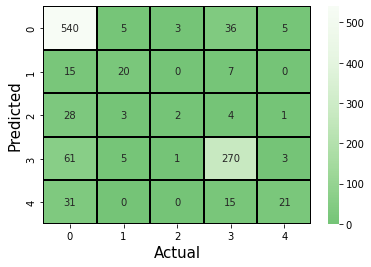

In [12]:
heatmap = sns.heatmap(confusion_matrix(yhat,y,output_dim),annot=True,fmt="0000.0f",
            #xticklabels=labels,
            #yticklabels=labels,
            linecolor='black',
            linewidths=0.1,
            cmap='Greens_r',
            center=0,
           )

plt.xlabel('Actual', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Predicted', fontsize = 15) # y-axis label with fontsize 15

In [13]:
average='weighted'

In [14]:
from torchmetrics.functional import accuracy, precision, recall, specificity, f1,auroc

In [15]:
x = classification_report(y,yhat)
print(x)

              precision    recall  f1-score   support

           0       0.80      0.92      0.85       589
           1       0.61      0.48      0.53        42
           2       0.33      0.05      0.09        38
           3       0.81      0.79      0.80       340
           4       0.70      0.31      0.43        67

    accuracy                           0.79      1076
   macro avg       0.65      0.51      0.54      1076
weighted avg       0.77      0.79      0.77      1076



In [16]:
recall(yhat,y,num_classes=output_dim, average=average)*100

tensor(79.2751)

In [17]:
precision(yhat,y,num_classes=output_dim, average=average)*100

tensor(77.3910)

In [18]:
accuracy(yhat,y)*100

tensor(79.2751)

In [19]:
auroc(yprob,y,num_classes=output_dim,average=average)*100

tensor(91.9661)

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
conf_mat = confusion_matrix(y,yhat)
conf_mat

array([[540,   5,   3,  36,   5],
       [ 15,  20,   0,   7,   0],
       [ 28,   3,   2,   4,   1],
       [ 61,   5,   1, 270,   3],
       [ 31,   0,   0,  15,  21]])

In [22]:
TP = conf_mat[1,1] # true positive 
TN = conf_mat[0,0] # true negatives
FP = conf_mat[0,1] # false positives
FN = conf_mat[1,0] # false negatives

In [23]:
acc = (TP+TN)/(conf_mat.sum())*100
acc

52.04460966542751

In [24]:
sens = TP/(TP+FN)*100
sens

57.14285714285714

In [25]:
spec = TP/(TP+FP)*100
spec

80.0

In [26]:
auroc(yprob,y,num_classes=2)*100

ValueError: Argument `num_classes` was set to 2 in metric `precision_recall_curve` but detected 5 number of classes from predictions